In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps

In [4]:
# Code up a mixed membership model 
random.seed(222)
np.random.seed(222)

K=3
n= 300
d=3

# Generate B matrix - this has 0.2 for all off-diagonal entries
B = np.ones((K, K)) * 0.2
comm_probs = np.linspace(0.3, 0.9, K)
np.fill_diagonal(B, comm_probs)

# make all the pi vectors (n of them)
pi_list = []
largest_prob = []

for i in range(n):
    # pi is a random probability vector of length K
    pi = np.random.dirichlet(np.ones(K)).reshape((K, 1))
    pi_list.append(pi)
    largest_prob.append(np.argmax(pi))


"""Generate M samples from the same model with the same B matrix and pi vectors"""
M=300
A_true_draws = []

for m in range(M):
    # use the B matrix from before, B, and the pi vectors, pi_list
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            z_ij = np.random.multinomial(1, pi_list[i].flatten())#.tolist())
            z_ji = np.random.multinomial(1, pi_list[j].flatten())#.tolist())

            P[i,j] = z_ij @ B @ z_ji.T

    A = (np.random.uniform(0, 1, n**2).reshape(n, n) < P)

    A = A.astype(float)

    A_true_draws.append(A)

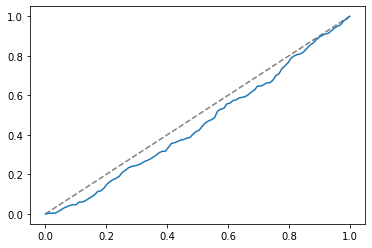

0.02

In [5]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)

k=10

p_vals = []
A_boots_list = []

for m in A_true_draws:
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=2000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

# Plot the ROC curve
plot_power(p_vals, plot=True)

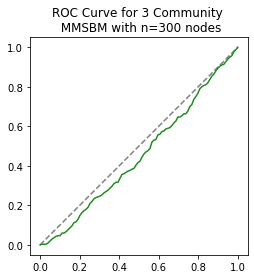

In [7]:
p_hat_list = p_vals
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for 3 Community \n MMSBM with n=300 nodes")
plt.gca().set_aspect('equal', adjustable='box')



In [50]:
"""Code up a mixed membership model and change the alpha vector values"""
random.seed(222)
np.random.seed(222)

K=3
n= 300
d=3

# Generate B matrix - this has 0.2 for all off-diagonal entries
B = np.ones((K, K)) * 0.2
comm_probs = np.linspace(0.3, 0.9, K)
np.fill_diagonal(B, comm_probs)

# Create a list of alpha vectors to try
alpha_list = [np.ones(K), 
                np.array((1,1,2)),
                np.array((1,1,3)),
                np.array((1,1,5)),
                np.array((1,1,10)),
                np.array((1,2,3)),
                np.array((1,3,5)),
                np.array((1,5,10)),
                np.array((1,2,2)),
                np.array((1,3,3)),
                np.array((1,5,5)),
                np.array((1,10,10))              
            ]

scores = []

for a in range(len(alpha_list)):

    # make all the pi vectors (n of them)
    pi_list = []
    largest_prob = []

    for i in range(n):
        # pi is a random probability vector of length K
        pi = np.random.dirichlet(alpha_list[a]).reshape((K, 1))
        pi_list.append(pi)
        largest_prob.append(np.argmax(pi))


    """Generate M samples from the same model with the same B matrix and pi vectors"""
    M=300
    A_true_draws = []

    for m in range(M):
        # use the B matrix from before, B, and the pi vectors, pi_list
        P = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                z_ij = np.random.multinomial(1, pi_list[i].flatten())#.tolist())
                z_ji = np.random.multinomial(1, pi_list[j].flatten())#.tolist())

                P[i,j] = z_ij @ B @ z_ji.T

        A = (np.random.uniform(0, 1, n**2).reshape(n, n) < P)
        A = A.astype(float)
        A_true_draws.append(A)


    # for each of the true draws from the model, create a bootstrap and perform a test with Q permutations

    k = 10 #fixed

    p_vals = []
    A_boots_list = []

    for m in A_true_draws:
        p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=k)
        p_vals.append(p_val)
        A_boots_list.append(A_boots)

    # Provided code
    p_hat_list = p_vals
    roc = []
    alphas = []

    for alpha in np.linspace(0, 1, 100):
        alphas.append(alpha)
        num_below_alpha = sum(p_hat_list < alpha)
        roc_point = num_below_alpha / len(p_hat_list)
        roc.append(roc_point)

    # Get the power at the 5% significance level
    power_significance = 0.05
    power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
    power = roc[power_idx]

    # plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
    # _ = plt.plot(alphas, roc, color='#228B22')

    # # Set title and aspect ratio
    # plt.title(f"ROC Curve for MMSBM with alpha={alpha_list[a]}")
    # plt.gca().set_aspect('equal', adjustable='box')

    # plt.show()

    # Calculate the area between ROC and y=x line
    def compute_area_above_below_curve(x, y):
        area_above = 0.0
        area_below = 0.0
        
        for i in range(1, len(x)):
            x0, x1 = x[i - 1], x[i]
            y0, y1 = y[i - 1], y[i]
            line0, line1 = x0, x1  # Since line y = x
            
            if y1 == y0:  # Vertical segment
                if y0 > x0:
                    area_above += (y0 - x0) * (x1 - x0)
                else:
                    area_below += (x0 - y0) * (x1 - x0)
                continue
            
            # Find intersection with y = x
            if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
                if y0 >= x0 and y1 >= x1:
                    area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
                else:
                    area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
            else:
                x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
                if y0 < x0:
                    area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                    area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
                else:
                    area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                    area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
        
        return area_above, area_below

    x = np.linspace(0, 1, 100)
    roc_interpolated = np.interp(x, alphas, roc)

    # Compute areas
    area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
    total_area = area_above + area_below

    # print(f"Area above the y=x line: {area_above}")
    # print(f"Area below the y=x line: {area_below}")
    print(f"Total area (above and below y=x): {total_area} for alpha={alpha_list[a]}")

    # add to lists
    scores.append(total_area)

Total area (above and below y=x): 0.037410554890812034 for alpha=[1. 1. 1.]
Total area (above and below y=x): 0.0824548515457607 for alpha=[1 1 2]
Total area (above and below y=x): 0.026643465570921936 for alpha=[1 1 3]
Total area (above and below y=x): 0.06280002349791146 for alpha=[1 1 5]
Total area (above and below y=x): 0.0937621790514352 for alpha=[ 1  1 10]
Total area (above and below y=x): 0.05700132639526584 for alpha=[1 2 3]
Total area (above and below y=x): 0.0671849811243751 for alpha=[1 3 5]
Total area (above and below y=x): 0.06844194006177481 for alpha=[ 1  5 10]
Total area (above and below y=x): 0.06864325841828144 for alpha=[1 2 2]
Total area (above and below y=x): 0.041456083640197545 for alpha=[1 3 3]
Total area (above and below y=x): 0.05363330272421185 for alpha=[1 5 5]
Total area (above and below y=x): 0.09119375573921036 for alpha=[ 1 10 10]


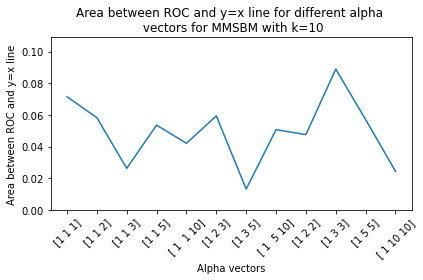

In [42]:
# Convert arrays to strings
x_labels = [str(arr) for arr in alpha_list]
# remove the full stops from x_labels[0]
x_labels[0] = "[1 1 1]"

plt.plot(scores)
plt.xticks(range(len(alpha_list)), x_labels, rotation=45)
plt.title("Area between ROC and y=x line for different alpha \n vectors for MMSBM with k=10")
plt.xlabel("Alpha vectors")
plt.ylabel("Area between ROC and y=x line")
# make yaxis go from 0
plt.ylim(0, max(scores)+0.02)

# make background white
plt.gcf().patch.set_facecolor('white')
# the bottom of plot getting cut off in savefig
plt.tight_layout()

plt.savefig("area_roc_mmsbm_alpha_scores.png", dpi=300)
plt.show()

In [44]:
# put scores and x_labels into a dataframe
df = pd.DataFrame({"alpha": x_labels, "score": scores})
df.to_csv("mmsbm_alpha_scores.csv", index=False)

### For each alpha, plot one draw from the model and one bootstrap of this draw on top

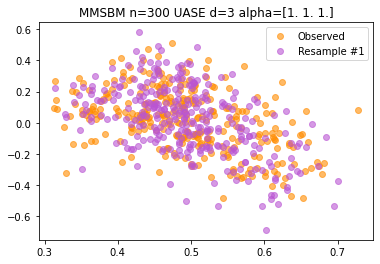

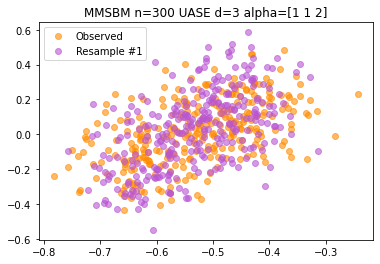

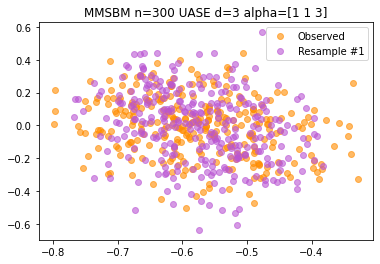

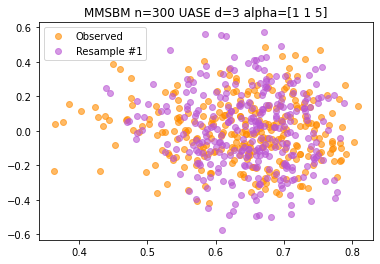

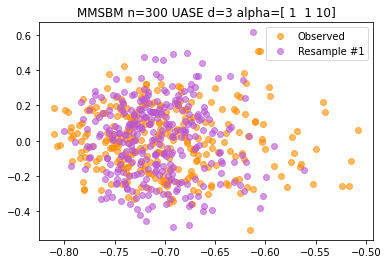

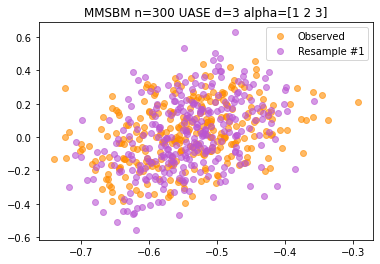

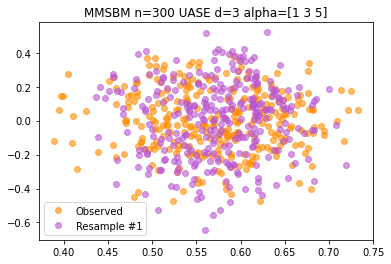

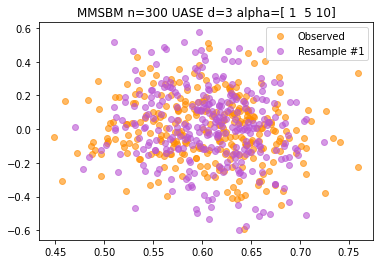

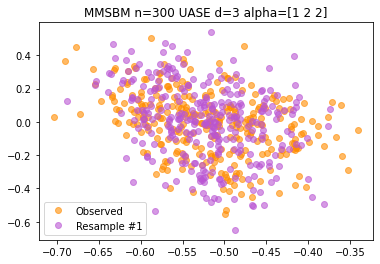

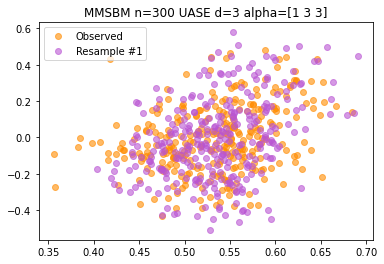

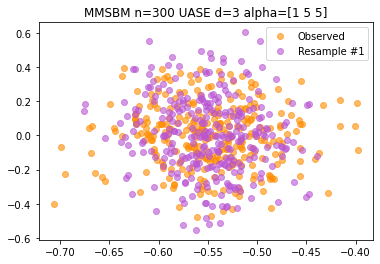

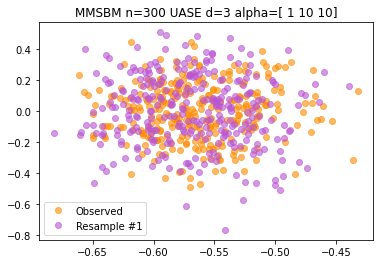

In [49]:
random.seed(222)
np.random.seed(222)

for a in range(len(alpha_list)):

    # make all the pi vectors (n of them)
    pi_list = []
    largest_prob = []

    for i in range(n):
        # pi is a random probability vector of length K
        pi = np.random.dirichlet(alpha_list[a]).reshape((K, 1))
        pi_list.append(pi)
        largest_prob.append(np.argmax(pi))


    """Generate 1 samples from the same model with the same B matrix and pi vectors"""
    # use the B matrix from before, B, and the pi vectors, pi_list
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            z_ij = np.random.multinomial(1, pi_list[i].flatten())#.tolist())
            z_ji = np.random.multinomial(1, pi_list[j].flatten())#.tolist())

            P[i,j] = z_ij @ B @ z_ji.T

    A = (np.random.uniform(0, 1, n**2).reshape(n, n) < P)
    A = A.astype(float)

    # for the true draw from the model, create a bootstrap 
    k = 10 #fixed
    p_val, A_boots = create_single_kNN_bootstrap(A, d=d, Q=1000, n_neighbors=k)

    # plot the draw and the bootstrap for this alpha embedded via UASE
    yhat = UASE([A,A_boots], d=d, flat=False)

    plt.plot(yhat[0, :, 0], yhat[0, :, 1], 'o', label="Observed", alpha=0.6, color='#FF8C00')
    plt.plot(yhat[1, :, 0], yhat[1, :, 1], 'o', label="Resample #1", alpha=0.6, color='#BA55D3')
    # plt.plot(yhat_est[2, :, 0], yhat_est[2, :, 1], 'o', label="Resampled", alpha=1)
    plt.legend()
    plt.title(f"MMSBM n=300 UASE d=3 alpha={alpha_list[a]}")
    plt.show()
    # plt.savefig("MMSBM_n300_UASE_d3_alpha{a}.png")